In [63]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

In this step, Loaded the three main datasets for analysis: design parameters, the real component of S11, and the imaginary component of S11. These datasets form the foundation of our analysis.

In [64]:
# Step 1: Load the datasets
input_df = pd.read_csv("hw1_input.csv")
real_df = pd.read_csv("hw1_real.csv")
img_df = pd.read_csv("hw1_img.csv")

I checked for missing values in the datasets. Since no missing values were found, we proceeded with the analysis without needing any data cleaning steps.

In [65]:
# Step 2: Check for missing values
missing_values = {
    "input_missing": input_df.isnull().sum().sum(),
    "real_missing": real_df.isnull().sum().sum(),
    "img_missing": img_df.isnull().sum().sum()
}
print("Missing values:", missing_values)

Missing values: {'input_missing': 0, 'real_missing': 0, 'img_missing': 0}


Calculated the S11 magnitude and visualized the magnitude profiles for 20 randomly selected designs. This graph allows us to compare the performance of different designs across frequency ranges.

<Figure size 1000x600 with 0 Axes>

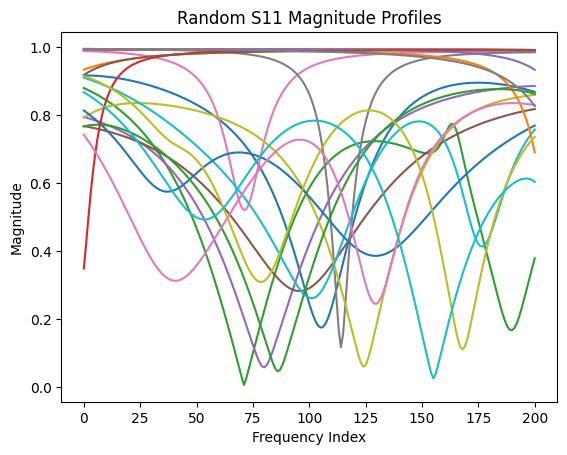

In [66]:
# Step 3: Visualize random magnitude profiles
magnitude_df = (real_df**2 + img_df**2) ** 0.5
random_samples = magnitude_df.sample(20).T
plt.figure(figsize=(10, 6))
random_samples.plot(legend=False)
plt.xlabel("Frequency Index")
plt.ylabel("Magnitude")
plt.title("Random S11 Magnitude Profiles")
plt.show()

The distributions of the design parameters were visualized. These distributions help us understand the possible ranges of each parameter and their variation within the dataset.

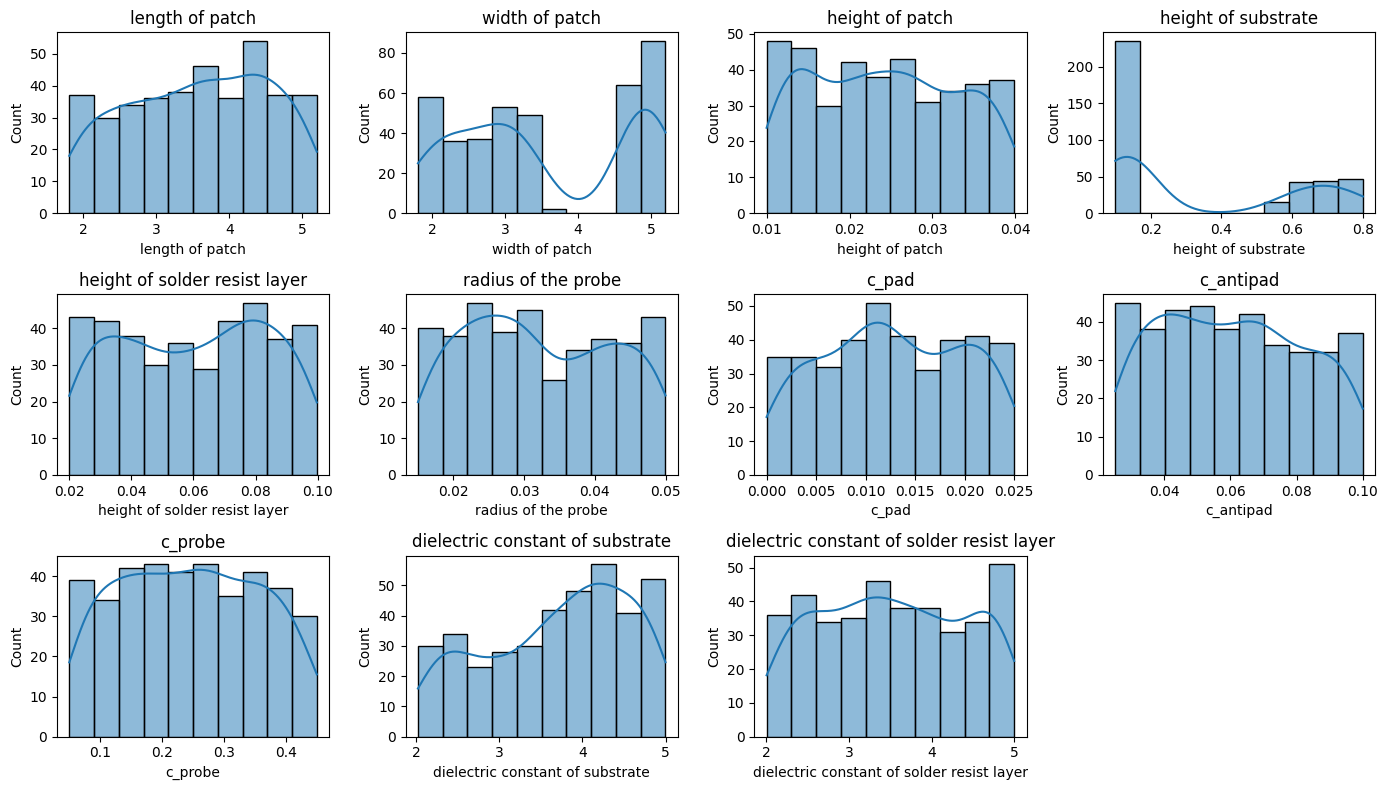

In [67]:
# Step 4: Visualize design parameter distributions
plt.figure(figsize=(14, 8))
for i, col in enumerate(input_df.columns):
    plt.subplot(3, 4, i + 1)
    sns.histplot(input_df[col], kde=True)
    plt.title(col)
plt.tight_layout()
plt.show()

Acceptable ranges for each design parameter were defined, and values outside these ranges were replaced with the median or mean. This step helped to improve the reliability of the dataset.



In [68]:
# Step 5: Define acceptable ranges and clean data
ranges = np.array([
    [1.8, 5.2], [1.8, 5.2], [0.01, 0.04], [0.1, 0.8], [0.02, 0.1],
    [0.015, 0.05], [0.0, 0.025], [0.025, 0.1], [0.05, 0.45], [2, 5], [2, 5]
])

out_of_range_count = input_df.apply(
    lambda row: sum([not (ranges[i, 0] <= row[i] <= ranges[i, 1]) for i in range(len(row))]),
    axis=1
)
input_cleaned = input_df[out_of_range_count < 3]

After adjusting the out-of-range values, the parameter distributions of the cleaned dataset were visualized. These graphs illustrate the effect of the cleaning process.



In [69]:
# Step 6: Replace out-of-range values
changes_per_column = [0] * input_cleaned.shape[1]
for col_idx, col_name in enumerate(input_cleaned.columns):
    col_values = input_cleaned[col_name]
    col_median = col_values.median()
    col_mean = col_values.mean()
    col_variance = col_values.var()
    replacement_value = col_median if col_variance >= 0.3 else col_mean
    out_of_range_mask = ~((ranges[col_idx, 0] <= col_values) & (col_values <= ranges[col_idx, 1]))
    changes_per_column[col_idx] = out_of_range_mask.sum()
    input_cleaned.loc[out_of_range_mask, col_name] = replacement_value

The design parameters were standardized, and Principal Component Analysis (PCA) was applied. PCA helped us identify components that explain a large portion of the variance.

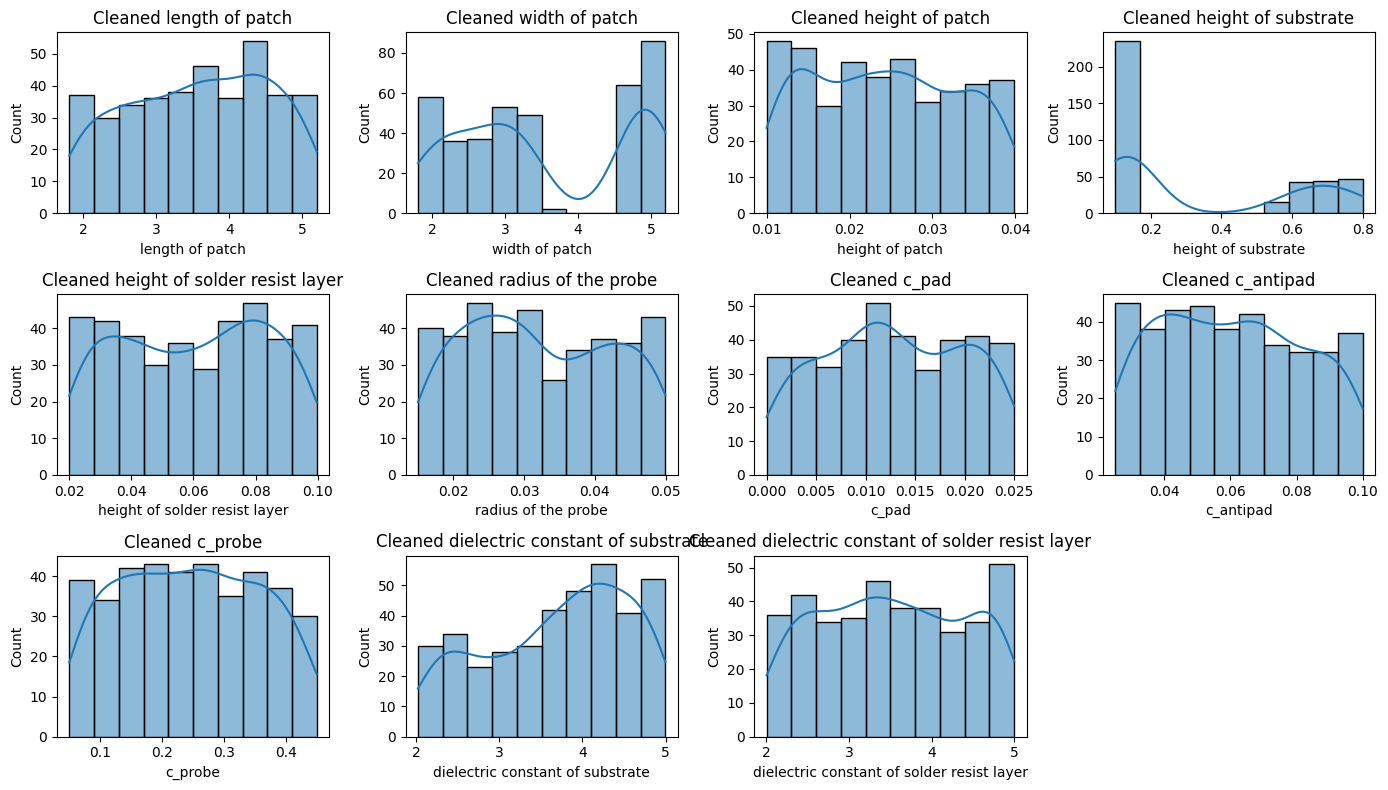

In [70]:
# Step 7: Visualize cleaned design parameters
plt.figure(figsize=(14, 8))
for i, col in enumerate(input_cleaned.columns):
    plt.subplot(3, 4, i + 1)
    sns.histplot(input_cleaned[col], kde=True)
    plt.title(f"Cleaned {col}")
plt.tight_layout()
plt.show()


The explained variance of each PCA component was visualized. This graph shows each component's contribution to the total variance and its cumulative effect.



In [71]:
# Step 8: Standardize data and apply PCA
scaler = StandardScaler()
input_scaled = scaler.fit_transform(input_cleaned)
pca = PCA()
pca_components = pca.fit_transform(input_scaled)
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

The loadings for the first two PCA components were analyzed. These loadings indicate which design parameters have the most influence on each component.



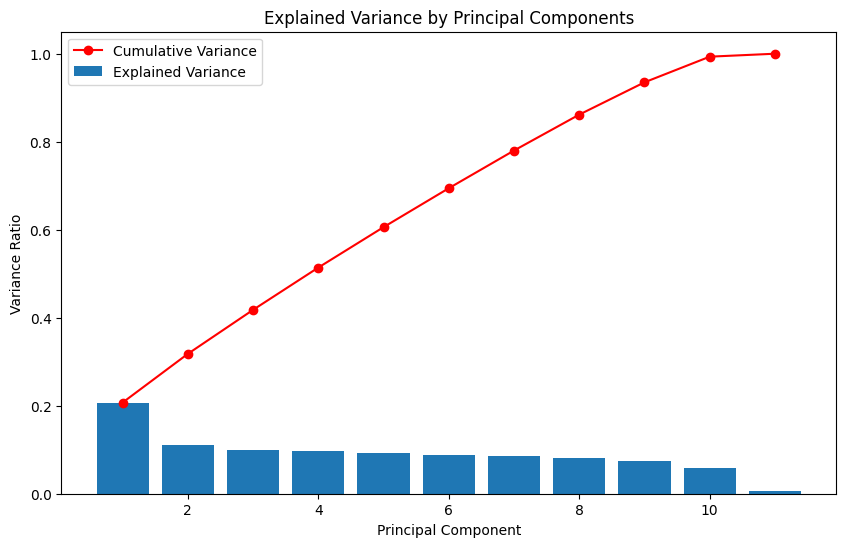

In [72]:
# Step 9: Visualize explained variance
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, label="Explained Variance")
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', color='r', label="Cumulative Variance")
plt.xlabel("Principal Component")
plt.ylabel("Variance Ratio")
plt.title("Explained Variance by Principal Components")
plt.legend()
plt.show()

The average S11 magnitude across all designs was analyzed and visualized. This analysis helps us understand the general performance of the antenna at different frequencies.

<Figure size 1000x600 with 0 Axes>

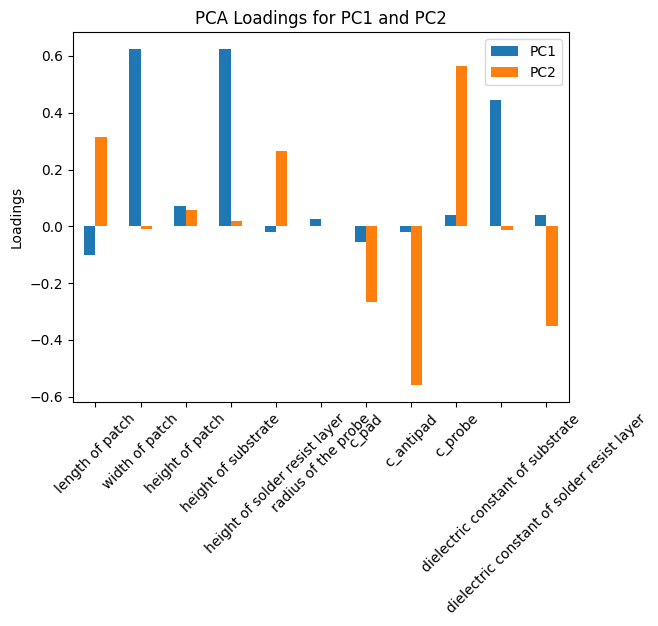

In [73]:
# Step 10: Visualize PCA loadings for first two components
pca_loadings = pd.DataFrame(pca.components_[:2].T, columns=["PC1", "PC2"], index=input_cleaned.columns)
plt.figure(figsize=(10, 6))
pca_loadings.plot(kind="bar")
plt.title("PCA Loadings for PC1 and PC2")
plt.ylabel("Loadings")
plt.xticks(rotation=45)
plt.show()

Key frequencies with the lowest average S11 magnitudes were identified. These frequencies represent resonance points of the antenna.

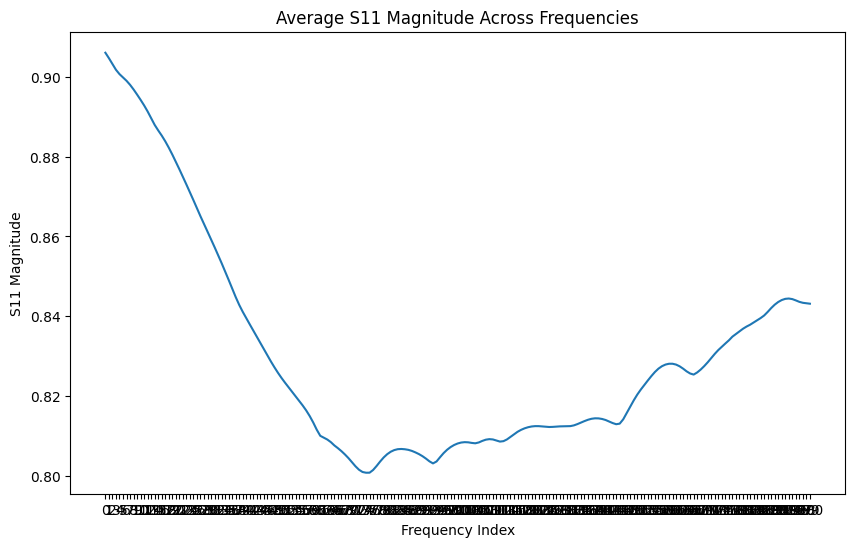

In [74]:
# Step 11: Analyze average S11 magnitude
mean_magnitude = magnitude_df.mean(axis=0)
plt.figure(figsize=(10, 6))
plt.plot(mean_magnitude)
plt.xlabel("Frequency Index")
plt.ylabel("S11 Magnitude")
plt.title("Average S11 Magnitude Across Frequencies")
plt.show()

Linear regression models were created to predict the S11 magnitude at key frequencies. The performance of the models was evaluated using error metrics.

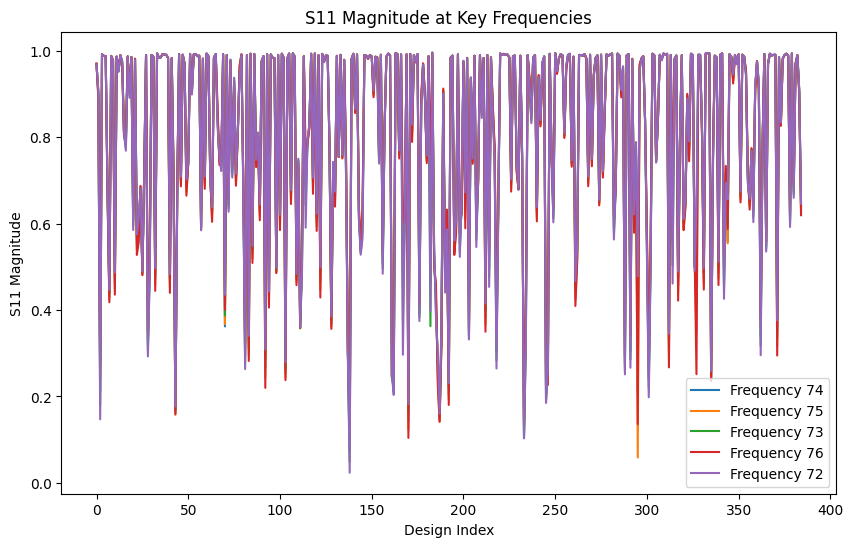

In [75]:
# Step 12: Highlight key frequencies
key_frequencies = mean_magnitude.nsmallest(5).index.tolist()
plt.figure(figsize=(10, 6))
for freq in key_frequencies:
    plt.plot(magnitude_df[freq], label=f"Frequency {freq}")
plt.xlabel("Design Index")
plt.ylabel("S11 Magnitude")
plt.title("S11 Magnitude at Key Frequencies")
plt.legend()
plt.show()

The regression coefficients for each key frequency were visualized. These coefficients show the influence of each design parameter on the S11 magnitude.

In [76]:
# Step 13: Perform linear regression on key frequencies
results = {}
X = input_cleaned
y = magnitude_df[key_frequencies]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

for freq in key_frequencies:
    y_train_freq = y_train[freq]
    y_test_freq = y_test[freq]
    model = LinearRegression()
    model.fit(X_train, y_train_freq)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test_freq, y_pred)
    mse = mean_squared_error(y_test_freq, y_pred)
    rmse = np.sqrt(mse)
    results[freq] = {
        "MAE": mae,
        "MSE": mse,
        "RMSE": rmse,
        "coefficients": pd.Series(model.coef_, index=X.columns),
    }


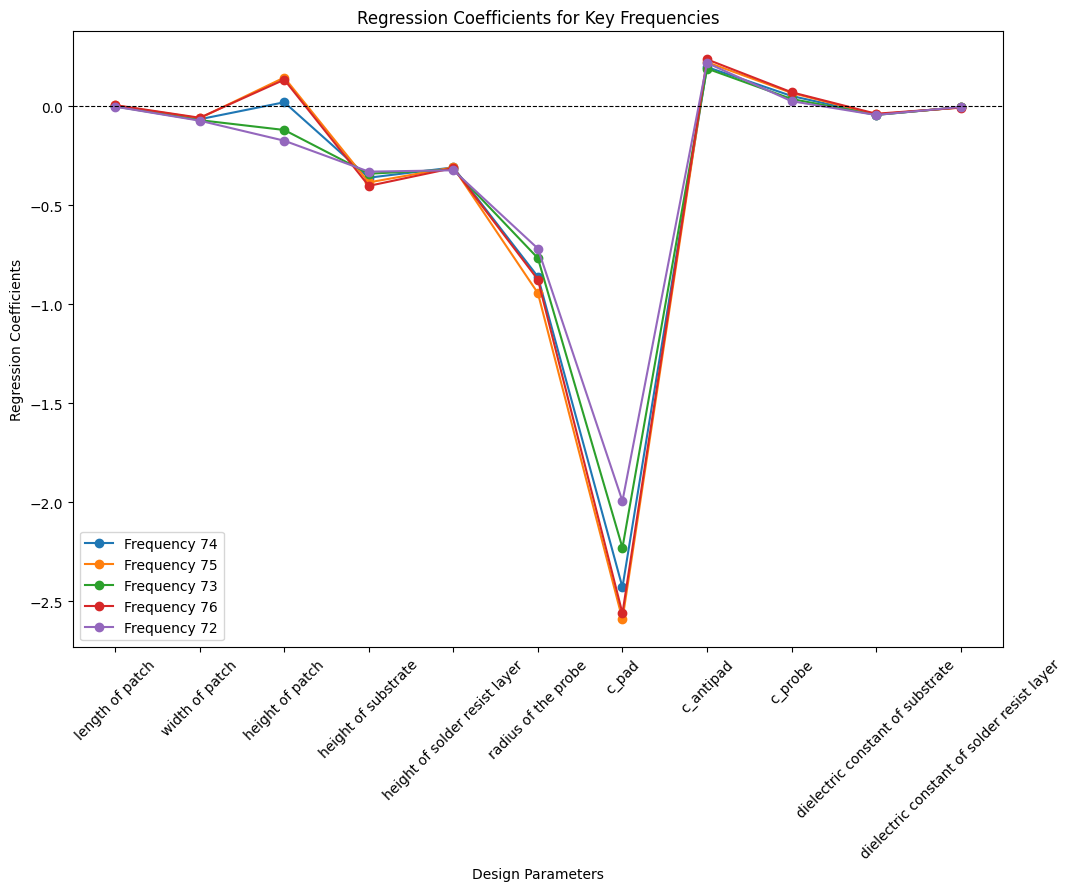

In [77]:
# Step 14: Visualize regression coefficients
plt.figure(figsize=(12, 8))
for freq in key_frequencies:
    coeffs = results[freq]["coefficients"]
    plt.plot(coeffs.index, coeffs.values, marker='o', label=f"Frequency {freq}")
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
plt.xticks(rotation=45)
plt.xlabel("Design Parameters")
plt.ylabel("Regression Coefficients")
plt.title("Regression Coefficients for Key Frequencies")
plt.legend()
plt.show()

## Model Performance and Interpretability
#### PCA and Complexity Reduction

PCA is used to reduce correlations between variables in the dataset and to decrease data dimensionality. However, in this assignment, we observed that PCA did not capture a significant amount of variance in the first few components. The first component explains 20% of the variance, while the second component explains 11%. These percentages indicate that PCA did not sufficiently reduce complexity in the dataset and provided limited explanatory power. Therefore, methods such as Linear Discriminant Analysis (LDA) or Independent Component Analysis (ICA) might be more effective in high-dimensional datasets with complex relationships.

#### Multiple Linear Regression Model and Limitations

The Multiple Linear Regression model used to predict the S11 magnitude achieved a maximum R² value of approximately 0.63 at certain frequencies (e.g., frequency 72). However, this value does not provide satisfactory accuracy for the entire dataset. Linear regression assumes a linear relationship between input and output variables, but the relationship between antenna design parameters and electromagnetic behavior is often nonlinear. This assumption limits the predictive accuracy of the model. Therefore, Polynomial Regression or other regression models might better capture such complex, nonlinear relationships.

#### Alternative Methods and Improvements

Although PCA and Linear Regression were used in this assignment, some alternative methods might perform better. For example:

Ridge Regression: To reduce multicollinearity, Ridge Regression can be used instead of PCA or Linear Regression. This method can help mitigate the effects of multicollinearity within the model and reduce the need for data preprocessing.
Regression Trees: There may be critical values in some input variables that are not captured by linear models. Regression Trees can be used to identify these critical values, which can inform the design of electromagnetic simulations by indicating key input values.
Conclusion

In this study, PCA and Linear Regression models were used to analyze the effects of antenna design parameters on frequency responses. However, due to nonlinear relationships and high complexity in the dataset, these methods have certain limitations. Alternative modeling approaches and data transformations could improve model performance and allow for a more effective analysis of antenna design. Therefore, it is recommended to explore more advanced modeling techniques and data transformation methods.

In the preparation of this report, I got help from regarding the syntax of the python language and understanding of the outputs.